## Task:

Susan has created a daily climatology of watershed discharges, based on monthly means. SEE:
https://github.com/SalishSeaCast/tools/blob/master/I_ForcingFiles/Rivers/SeasonalCyclesFromMonthlyMeans.ipynb

Daily files read into the model are currently in the form:
    
    "R201702DFraCElse_y2017m01d10.nc" 
stored in:
    
    /results/forcing/rivers
where the Fraser has a daily real-time value from the Hope gauge, and the rest of the rivers are the morison climatology. 

We need to create files of the above form, one file per day, except replacing the Morrison climatology with the interpolated climatology. Need to be v.v. careful with units, as m3/s units are not used in the model. 

    Rivers are treated like rain, added from above.  So kg of water/m2 /s where the m2 is horizontal area.  This we will call nf (nemo flux)
    So for m3/s first we convert from mass to volume
    nf / rho (fresh water so 1000 kg/m3)  so now we have m/s
    Then multiply by the area of the grid cell
     nf  / rho * e1t(i,j) *e2t(i,j)

The steps are as follows:

    1) Open the river climatology file from 
        rivers-climatology/watershed_climatologies/Salish_allrivers_daily.nc
    2) use the river properties dictionary, the 'prop' key to distribute the climatology among individual rivers, still in m3/s, and save in a new dictionary -
    3) translate from m3/s to kg/m2/s, save that into the new dictionary
             ie eg river "nooksack" will have 365 numbers, in kg/m2/s 
    4) create new daily files and populate them with the numbers from 3, using the i and j values found in the river properties dictionary. These daily files are of a similar type as "R201702DFraCElse_y2017m01d10.nc" 

In [79]:
%reset
import netCDF4 as nc
import numpy as np
import arrow
import matplotlib.pyplot as plt

import sys
sys.path.append('/data/tjarniko/MEOPAR/tools/SalishSeaTools/salishsea_tools/')
#import mocsy
import river_201702 as rv
import river_downbyone2 as rv2

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


### Trying to understand inconsistency between how rivers are seen in the different grids - using downbyone grid for the R201702DFraCElse_y2017m01d10.nc and other files...

In [80]:
sample_river_file = \
nc.Dataset('/results/forcing/rivers/R201702DFraCElse_y2015m07d25.nc')

#print(sample_river_file)

climatology_file = \
nc.Dataset('/data/tjarniko/MEOPAR/rivers-climatology/watershed_climatologies/Salish_allrivers_daily.nc')
#print(climatology_file['fraser'][300])

watersheds = ['howe', 'jdf', 'puget', 'skagit', 'fraser', \
              'evi_n', 'jervis', 'toba', 'bute', 'evi_s']

In [81]:
# import copy
# clim_dict = copy.deepcopy(rv.prop_dict)
# grid = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')

# watersheds = ['howe', 'jdf', 'puget', 'skagit', 'fraser', \
#               'evi_n', 'jervis', 'toba', 'bute', 'evi_s']

# for w in watersheds:
#     interp_clim = climatology_file[w][:]

#     print(w)
#     #print(interp_clim)
#     rivers = (rv.prop_dict[w].keys())
#     for r in rivers:
#         #print(r)
#         prop_wshed = rv.prop_dict[w][r]['prop']
#         clim_dict[w][r]['interp_clim'] = prop_wshed * interp_clim
#         river_i = rv.prop_dict[w][r]['j']
#         river_j = rv.prop_dict[w][r]['i']
#         river_dj = rv.prop_dict[w][r]['di']
#         river_di = rv.prop_dict[w][r]['dj']
#         area = grid['e1t'][0,river_j,river_i]*grid['e2t'][0,river_j,river_i]
#         clim_dict[w][r]['interp_clim_modunits'] = prop_wshed * interp_clim / area * 1000
#        # if ((river_dj > 1) | (river_di > 1)):
#        #     print(r)
#        #     print(rv2.prop_dict[w][r])
# #runoff_m3 = (year_runoff / 1000) * t_area
# #runoff in model units = runoff_m3 / t_area * 1000 



#### checking the Squamish river interpolated result against a daily file

#### checking the homathko river interpolated result against a daily file

In [82]:
# print(rv.prop_dict['bute'])


# riv_i = clim_dict['bute']['Homathko']['i']
# riv_j = clim_dict['bute']['Homathko']['j']
# riv_di = clim_dict['bute']['Homathko']['di']
# riv_dj = clim_dict['bute']['Homathko']['dj']
# print(riv_i)
# #print(sample_river_file['rorunoff'][0,532-2:532+2,385-2:385+2])
# print(sample_river_file['rorunoff'][0,riv_i:riv_i+riv_di,riv_j:riv_j+riv_dj])
# print(clim_dict['bute']['Homathko']['interp_clim_modunits'][219])



### 

#### THIS CODE CALCULATES THE APPROPRIATE DAILY CLIMATOLOGY FOR EACH RIVER, THEN (IF verbose == true) COMPARES IT FOR A SAMPLE DAY WITH THE MONTHLY CLIMATOLOGY FILE

In [83]:
# frasers = ['Fraser1','Fraser2','Fraser3','Fraser4']

# twit = 'Fraser1'

# twit not in frasers

## rotate by 45 days forward

In [84]:
import copy
clim_dict = copy.deepcopy(rv.prop_dict)
grid = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')

watersheds = ['howe', 'jdf', 'puget', 'skagit', 'fraser', \
              'evi_n', 'jervis', 'toba', 'bute', 'evi_s']

#print(np.shape(sample_river_file['rorunoff'][0,:,:]))
#print(np.max((sample_river_file['rorunoff'][0,:,:])))
verbose = False
frasers = ['Fraser']
for w in watersheds:
    interp_clim = climatology_file[w][:]
    #print('')
    print(w)
    #print(interp_clim)
    rivers = (rv.prop_dict[w].keys())
    for r in rivers:
        if (r not in frasers):

            prop_wshed = rv.prop_dict[w][r]['prop']
            clim_dict[w][r]['interp_clim'] = prop_wshed * interp_clim
            river_i = rv.prop_dict[w][r]['j']
            river_di = rv.prop_dict[w][r]['dj']

            river_j = rv.prop_dict[w][r]['i']
            river_dj = rv.prop_dict[w][r]['di']
            area = grid['e1t'][0,river_j,river_i]*grid['e2t'][0,river_j,river_i]
            clim_dict[w][r]['interp_clim_modunits'] = prop_wshed * interp_clim / area * 1000
            size_inflow = river_di * river_dj
            if verbose == True:
                print(r)
                print(size_inflow)
                print('sample river file runoff')
                print(sample_river_file['rorunoff'][0,river_j:river_j+river_dj,river_i:river_i+river_di])
                print(sample_river_file['rorunoff'][0,river_j-1:river_j+river_dj+1,river_i-1:river_i+river_di+1])
                print('daily climatology result: ' + str(clim_dict[w][r]['interp_clim_modunits'][219]))
                print('')
        

howe
jdf
puget
skagit
fraser
evi_n
jervis
toba
bute
evi_s


In [85]:
sample_river_file = \
nc.Dataset('/results/forcing/rivers/R201702DFraCElse_y2015m07d25.nc')

#print(sample_river_file)

print(rv.prop_dict['howe'])


riv_i = clim_dict['howe']['Squamish']['i']
riv_j = clim_dict['howe']['Squamish']['j']
riv_di = clim_dict['howe']['Squamish']['di']
riv_dj = clim_dict['howe']['Squamish']['dj']
print(riv_i)
#print(sample_river_file['rorunoff'][0,532-2:532+2,385-2:385+2])
print(sample_river_file['rorunoff'][0,riv_i:riv_i+riv_di,riv_j:riv_j+riv_dj])
print(clim_dict['howe']['Squamish']['interp_clim_modunits'][219])

#(rivdat.variables['rorunoff'][8,534,384:386])


{'Squamish': {'prop': 0.9, 'i': 534, 'j': 384, 'di': 1, 'dj': 2, 'depth': 2}, 'Burrard': {'prop': 0.1, 'i': 457, 'j': 343, 'di': 3, 'dj': 1, 'depth': 3}}
534
[[1.8686054 1.8686054]]
3.2455642


In [86]:
rivers = (rv.prop_dict['fraser'].keys())
for r in rivers:
    print(r)
    print(rv.prop_dict['fraser'][r])
    
print(rv.prop_dict)

Dakota
{'prop': 0.00096, 'i': 363, 'j': 357, 'di': 1, 'dj': 1, 'depth': 1}
Terrel
{'prop': 0.00064, 'i': 353, 'j': 350, 'di': 1, 'dj': 1, 'depth': 1}
Nooksack
{'prop': 0.012, 'i': 312, 'j': 354, 'di': 1, 'dj': 4, 'depth': 1}
Squallum
{'prop': 0.0008, 'i': 305, 'j': 365, 'di': 1, 'dj': 1, 'depth': 1}
Lakethingo
{'prop': 0.00096, 'i': 302, 'j': 367, 'di': 1, 'dj': 1, 'depth': 1}
Chuckanut
{'prop': 0.00064, 'i': 298, 'j': 361, 'di': 1, 'dj': 1, 'depth': 1}
Fraser
{'prop': 0.984, 'i': 500, 'j': 394, 'di': 1, 'dj': 1, 'depth': 3}
{'howe': {'Squamish': {'prop': 0.9, 'i': 534, 'j': 384, 'di': 1, 'dj': 2, 'depth': 2}, 'Burrard': {'prop': 0.1, 'i': 457, 'j': 343, 'di': 3, 'dj': 1, 'depth': 3}}, 'jdf': {'SanJuan': {'prop': 0.165, 'i': 401, 'j': 63, 'di': 1, 'dj': 1, 'depth': 1}, 'Gordon': {'prop': 0.07, 'i': 404, 'j': 64, 'di': 1, 'dj': 1, 'depth': 1}, 'Loss': {'prop': 0.025, 'i': 376, 'j': 72, 'di': 1, 'dj': 1, 'depth': 1}, 'Jordan': {'prop': 0.025, 'i': 349, 'j': 97, 'di': 1, 'dj': 1, 'depth':

In [87]:
start ='2017-01-01'
end ='2017-12-31'
frasers = ['Fraser']
verbose = False
start_run = arrow.get(start)
end_run = arrow.get(end)
wat_to_rot = ['skagit', 'howe', 'bute', 'toba']

import pickle
#pickle.dump(hydro_old_Fraser, open("hydroFraser_2017real.pkl", 'wb'))
hydroFraser_2017real = pickle.load(open('./hydroFraser_2017real.pkl', 'rb'))  

arrow_array = []

for r in arrow.Arrow.span_range('day', start_run, end_run):
    arrow_array.append(r)


for date in range(0,len(arrow_array)):
    print(date)
    #get appropriate date and open old river file
    tdate = arrow_array[date][0]
    y = tdate.format('YYYY')
    m = tdate.format('MM')
    d = tdate.format('DD')
    tday = f"y{y}m{m}d{d}"
    print(tday)
    trivfile = f"/results/forcing/rivers/R201702DFraCElse_y{y}m{m}d{d}.nc"
    triv = nc.Dataset(trivfile)
    #print(triv)
    
    ## open rorunoff file and copy it
    rorunoff = triv['rorunoff'][:]
    if verbose == True:
        print(np.shape(rorunoff))
    new_rorunoff = np.copy(rorunoff)
    
    #populate rorunoff with new climatology for ever river except the frasers
    for w in watersheds:
        #interp_clim = climatology_file[w][:]
        if verbose == True:
            print('')
            print(w)
        #print(interp_clim)
        rivers = (rv.prop_dict[w].keys())
        for r in rivers:
            if (r not in frasers):

                #prop_wshed = rv2.prop_dict[w][r]['prop']
                #clim_dict[w][r]['interp_clim'] = prop_wshed * interp_clim
                river_i = rv.prop_dict[w][r]['j']
                river_di = rv.prop_dict[w][r]['dj']

                river_j = rv.prop_dict[w][r]['i']
                river_dj = rv.prop_dict[w][r]['di']
                #area = grid['e1t'][0,river_j,river_i]*grid['e2t'][0,river_j,river_i]
                #clim_dict[w][r]['interp_clim_modunits'] = prop_wshed * interp_clim / area * 1000
                total_inflow = clim_dict[w][r]['interp_clim_modunits'][:]
                if w in wat_to_rot:
                    total_inflow = np.roll(total_inflow,-45)
                    
                todays_inflow = total_inflow[date]
                size_inflow = river_di * river_dj
                populate_inflow = todays_inflow/size_inflow
                new_rorunoff[0,river_j:river_j+river_dj,river_i:river_i+river_di] = populate_inflow
            
            if (r in frasers):

                #prop_wshed = rv2.prop_dict[w][r]['prop']
                #clim_dict[w][r]['interp_clim'] = prop_wshed * interp_clim
                river_i = rv.prop_dict[w][r]['j']
                river_di = rv.prop_dict[w][r]['dj']

                river_j = rv.prop_dict[w][r]['i']
                river_dj = rv.prop_dict[w][r]['di']
                #area = grid['e1t'][0,river_j,river_i]*grid['e2t'][0,river_j,river_i]
                #clim_dict[w][r]['interp_clim_modunits'] = prop_wshed * interp_clim / area * 1000
                total_inflow = hydroFraser_2017real
                total_inflow = np.roll(total_inflow,-45)
#                 if w in wat_to_rot:
#                     total_inflow = np.roll(total_inflow,-45)
                    
                todays_inflow = total_inflow[date]
                size_inflow = river_di * river_dj
                populate_inflow = todays_inflow/size_inflow
                new_rorunoff[0,river_j:river_j+river_dj,river_i:river_i+river_di] = populate_inflow                

            if verbose == True:
                print(r)
                print(size_inflow)
                print('daily climatology result: ' + str(clim_dict[w][r]['interp_clim_modunits'][date]))
                print('')


    
    ### code to copy the new rivers file into its own .nc
    dsin = triv
    newrivfile = f"./daily_45Dearly/R201702DFraDailyElse45Dearly_y{y}m{m}d{d}.nc"
    ncname = newrivfile
    print(newrivfile)
    
    dsout = nc.Dataset(ncname, "w", format="NETCDF4")
    #Copy dimensions
    for dname, the_dim in dsin.dimensions.items():
        #print(dname)
        #print(len(the_dim))
        dsout.createDimension(dname, len(the_dim) if not the_dim.isunlimited() else None)
    # Copy variables
    for v_name, varin in dsin.variables.items():
        #print(v_name)
        outVar = dsout.createVariable(v_name, varin.datatype, varin.dimensions)
        #print(varin.datatype)
        outVar.setncatts({k: varin.getncattr(k) for k in varin.ncattrs()})
        outVar[:] = varin[:]
    dsout['rorunoff'][:] = new_rorunoff
    dsout.close()

0
y2017m01d01
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m01d01.nc
1
y2017m01d02
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m01d02.nc
2
y2017m01d03
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m01d03.nc
3
y2017m01d04
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m01d04.nc
4
y2017m01d05
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m01d05.nc
5
y2017m01d06
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m01d06.nc
6
y2017m01d07
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m01d07.nc
7
y2017m01d08
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m01d08.nc
8
y2017m01d09
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m01d09.nc
9
y2017m01d10
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m01d10.nc
10
y2017m01d11
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m01d11.nc
11
y2017m01d12
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m01d12.nc
12
y2017m01d13
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m01d13.nc
13
y2017m01d14
./daily

./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m04d19.nc
109
y2017m04d20
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m04d20.nc
110
y2017m04d21
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m04d21.nc
111
y2017m04d22
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m04d22.nc
112
y2017m04d23
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m04d23.nc
113
y2017m04d24
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m04d24.nc
114
y2017m04d25
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m04d25.nc
115
y2017m04d26
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m04d26.nc
116
y2017m04d27
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m04d27.nc
117
y2017m04d28
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m04d28.nc
118
y2017m04d29
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m04d29.nc
119
y2017m04d30
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m04d30.nc
120
y2017m05d01
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m05d01.nc
121
y2017m05d02

215
y2017m08d04
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m08d04.nc
216
y2017m08d05
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m08d05.nc
217
y2017m08d06
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m08d06.nc
218
y2017m08d07
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m08d07.nc
219
y2017m08d08
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m08d08.nc
220
y2017m08d09
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m08d09.nc
221
y2017m08d10
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m08d10.nc
222
y2017m08d11
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m08d11.nc
223
y2017m08d12
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m08d12.nc
224
y2017m08d13
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m08d13.nc
225
y2017m08d14
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m08d14.nc
226
y2017m08d15
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m08d15.nc
227
y2017m08d16
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m08d16.nc

./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m11d23.nc
327
y2017m11d24
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m11d24.nc
328
y2017m11d25
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m11d25.nc
329
y2017m11d26
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m11d26.nc
330
y2017m11d27
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m11d27.nc
331
y2017m11d28
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m11d28.nc
332
y2017m11d29
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m11d29.nc
333
y2017m11d30
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m11d30.nc
334
y2017m12d01
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m12d01.nc
335
y2017m12d02
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m12d02.nc
336
y2017m12d03
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m12d03.nc
337
y2017m12d04
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m12d04.nc
338
y2017m12d05
./daily_45Dearly/R201702DFraDailyElse45Dearly_y2017m12d05.nc
339
y2017m12d06

### Check that the river daily files are populated exactly where the old ones were

In [88]:
new_rivfile = nc.Dataset(f"./daily_45Dearly/R201702DFraDailyElse45Dearly_y{y}m{m}d{d}.nc")
old_rivfile = nc.Dataset(f"/results/forcing/rivers/R201702DFraCElse_y{y}m{m}d{d}.nc")

new_runoff = new_rivfile['rorunoff'][:]
old_runoff = old_rivfile['rorunoff'][:]

populated_new = np.where(new_runoff != 0)
print(np.shape(populated_new))

populated_old = np.where(old_runoff != 0)
print(np.shape(populated_old))

pn = np.array(populated_new)
po = np.array(populated_old)
print(pn == po)

# comparison = populated_new == populated_old
# equal_arrays = comparison.all()
# print(equal_arrays)

# an_array = np.array([[1,2],[3,4]])
# another_array = np.array([[1,2],[3,4]])

# comparison = populated_old == another_array
# equal_arrays = comparison.all()
# print(equal_arrays)

# def cmpT(t1, t2): 
#   return sorted(t1) == sorted(t2)

# cmpT(populated_old,populated_new)

(3, 182)
(3, 182)
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True 

In [89]:
type(populated_old)

tuple

In [90]:
def compare_hydrographs_for_a_given_river(wshed, river):
    
    w = wshed
    r = river
    
    hydro_old = np.zeros(365)
    hydro_new = np.zeros(365)
    
    river_i = rv.prop_dict[w][r]['j']
    river_di = rv.prop_dict[w][r]['dj']
    river_j = rv.prop_dict[w][r]['i']
    river_dj = rv.prop_dict[w][r]['di']

    start ='2017-01-01'
    end ='2017-12-31'
    
    verbose = False
    start_run = arrow.get(start)
    end_run = arrow.get(end)
    arrow_array = []

    for r in arrow.Arrow.span_range('day', start_run, end_run):
        arrow_array.append(r)
        
    for date in range(0,len(arrow_array)):
        #print(date)
        #get appropriate date and open old river file
        tdate = arrow_array[date][0]
        y = tdate.format('YYYY')
        m = tdate.format('MM')
        d = tdate.format('DD')
        tday = f"y{y}m{m}d{d}"
        #print(tday)
        trivfile = f"/results/forcing/rivers/R201702DFraCElse_y{y}m{m}d{d}.nc"
        triv = nc.Dataset(trivfile)
        newrivfile = f"./daily_45Dearly//R201702DFraDailyElse45Dearly_y{y}m{m}d{d}.nc"
        newriv = nc.Dataset(newrivfile)
        
        hydro_old[date] = np.sum(triv['rorunoff'][0,river_j:river_j+river_dj,river_i:river_i+river_di])
        hydro_new[date] = np.sum(newriv['rorunoff'][0,river_j:river_j+river_dj,river_i:river_i+river_di])
    
    return hydro_old, hydro_new

In [91]:
hydro_old_Squamish, hydro_new_Squamish = \
compare_hydrographs_for_a_given_river('howe', 'Squamish')
hydro_old_Homathko, hydro_new_Homathko = \
compare_hydrographs_for_a_given_river('bute', 'Homathko')
hydro_old_Powell, hydro_new_Powell = \
compare_hydrographs_for_a_given_river('jervis', 'Powell')
hydro_old_Toba, hydro_new_Toba = \
compare_hydrographs_for_a_given_river('toba', 'Toba')
hydro_old_Englishman, hydro_new_Englishman = \
compare_hydrographs_for_a_given_river('evi_s', 'Englishman')
hydro_old_SanJuan, hydro_new_SanJuan = \
compare_hydrographs_for_a_given_river('jdf', 'SanJuan')
hydro_old_Fraser, hydro_new_Fraser = \
compare_hydrographs_for_a_given_river('fraser', 'Fraser')

In [92]:
np.shape(hydro_old_Squamish)

(365,)

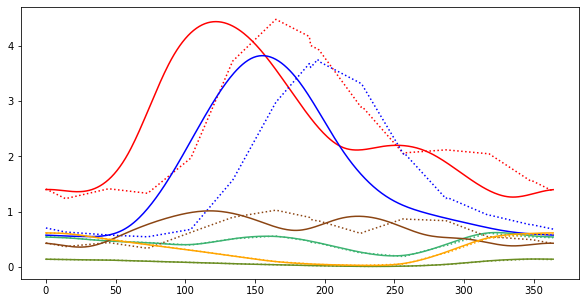

In [93]:
hydro_old_Squamish[364]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(np.arange(0,365,1),hydro_old_Squamish, \
        color = 'r', linestyle = ':',label = 'Squamish old')
ax.plot(np.arange(0,365,1),hydro_new_Squamish, \
        color = 'r', linestyle = '-',label = 'Squamish new')
ax.plot(np.arange(0,365,1),hydro_old_Homathko, \
        color = 'b', linestyle = ':',label = 'Homathko old')
ax.plot(np.arange(0,365,1),hydro_new_Homathko, \
        color = 'b', linestyle = '-',label = 'Homathko new')
ax.plot(np.arange(0,365,1),hydro_old_Powell, \
        color = 'mediumseagreen', linestyle = ':',label = 'Powell old')
ax.plot(np.arange(0,365,1),hydro_new_Powell, \
        color = 'mediumseagreen', linestyle = '-',label = 'Powell new')
ax.plot(np.arange(0,365,1),hydro_old_Toba, \
        color = 'saddlebrown', linestyle = ':',label = 'Toba old')
ax.plot(np.arange(0,365,1),hydro_new_Toba, \
        color = 'saddlebrown', linestyle = '-',label = 'Toba new')
ax.plot(np.arange(0,365,1),hydro_old_Englishman, \
        color = 'olivedrab', linestyle = ':',label = 'Englishman old')
ax.plot(np.arange(0,365,1),hydro_new_Englishman, \
        color = 'olivedrab', linestyle = '-',label = 'Englishman new')
ax.plot(np.arange(0,365,1),hydro_old_SanJuan, \
        color = 'orange', linestyle = ':',label = 'SanJuan old')
ax.plot(np.arange(0,365,1),hydro_new_SanJuan, \
        color = 'orange', linestyle = '-',label = 'SanJuan new')


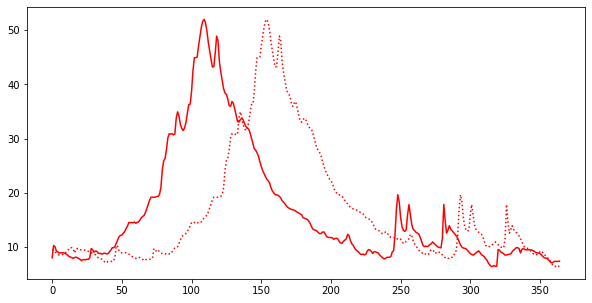

In [94]:
hydro_old_Fraser, hydro_new_Fraser = \
compare_hydrographs_for_a_given_river('fraser', 'Fraser')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(np.arange(0,365,1),hydro_old_Fraser, \
        color = 'r', linestyle = ':',label = 'Fraser old')
ax.plot(np.arange(0,365,1),hydro_new_Fraser, \
        color = 'r', linestyle = '-',label = 'Fraser new')